In [1]:
import h5py, os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from imp import reload
import pandas as pd
from sklearn.decomposition import PCA
from scipy.stats import spearmanr

from dca import analysis, data_util, style, DynamicalComponentsAnalysis

In [2]:
T_pi = 10
dim = 3
n_init = 5

In [3]:
data = []
X = data_util.load_sabes_data('neural/indy_20160627_01.mat')['M1']
unit = 'Neurons'
name = 'M1'
data.append((X, name, unit))

X = data_util.load_kording_paper_data('neural/example_data_hc.pickle')['neural']
unit = 'Neurons'
name = 'HC'
data.append((X, name, unit))

X = data_util.load_weather_data('weather/temperature.csv')
unit = 'Cities'
name = 'Temperature'
data.append((X, name, unit))

X = data_util.load_accel_data('accel/sub_19.csv')
unit = 'Sensors'
name = 'Accelerometer'
data.append((X, name, unit))

In [4]:
results = []
for X, name, unit in data:
    dca = DynamicalComponentsAnalysis(T=T_pi, d=dim, n_init=n_init)
    pca = PCA(n_components=3)
    Xd = PCA().fit_transform(dca.fit_transform(X))
    Xp = pca.fit_transform(X)
    
    dca_ls = np.linalg.norm(dca.coef_, axis=1)**2 / dim
    pca_ls = np.linalg.norm(pca.components_, axis=0)**2 / dim
    results.append((dca_ls, pca_ls, Xd, Xp))

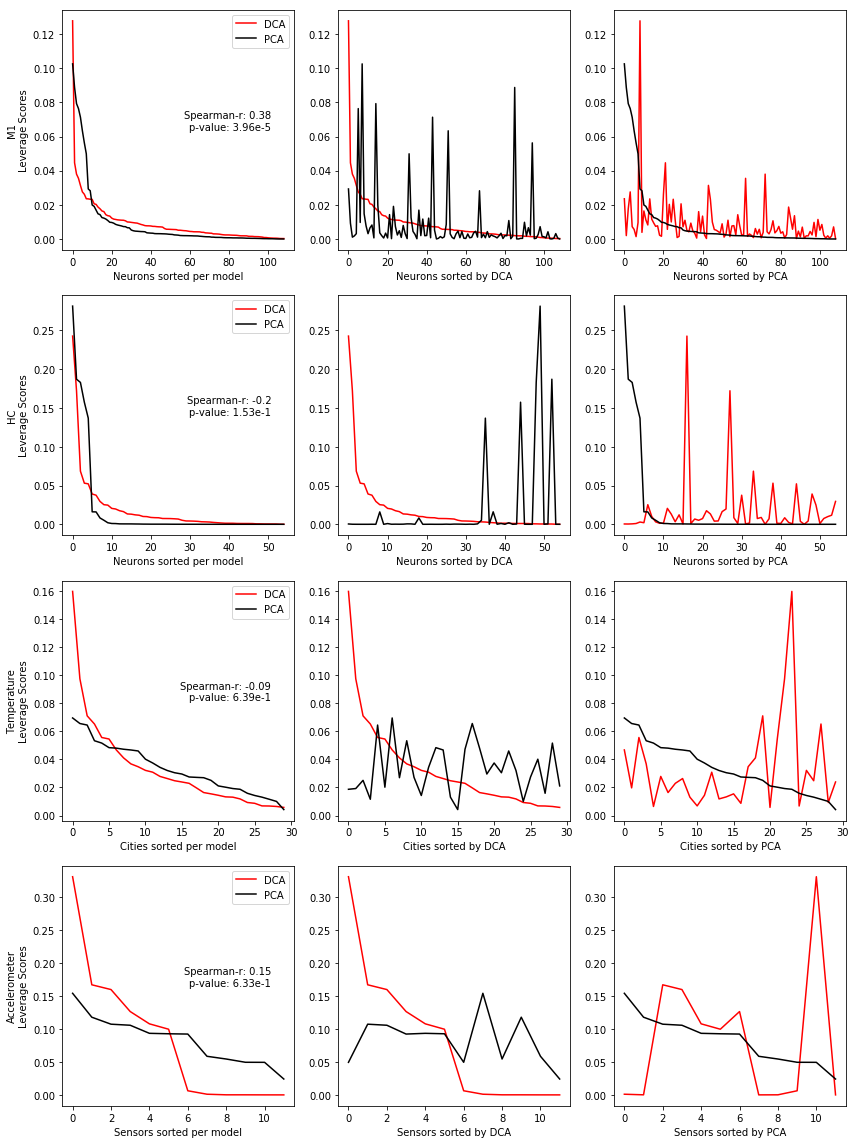

In [5]:
fig, axes_m = plt.subplots(4, 3, figsize=(12, 16))

for (_, name, unit), (dca_ls, pca_ls, _, _), axes in zip(data, results, axes_m):
    c, p = spearmanr(dca_ls, pca_ls)
    c = np.round(c, 2)
    pl10 = int(np.floor(np.log10(p)))
    pr = np.round(p / 10**pl10, 2)

    ax = axes[0]
    ax.plot(np.sort(dca_ls)[::-1], c='r', label='DCA')
    ax.plot(np.sort(pca_ls)[::-1], c='k', label='PCA')
    ax.set_xlabel('{} sorted per model'.format(unit))
    ax.set_ylabel('{}\nLeverage Scores'.format(name))
    ax.text(.9, .5, 'Spearman-r: {}\np-value: {}e{}'.format(c, pr, pl10),
            ha='right', transform=ax.transAxes)
    ax.legend()

    ax = axes[1]
    idxs = np.argsort(dca_ls)[::-1]
    ax.plot(dca_ls[idxs], c='r', label='DCA')
    ax.plot(pca_ls[idxs], c='k', label='PCA')
    ax.set_xlabel('{} sorted by DCA'.format(unit))

    ax = axes[2]
    idxs = np.argsort(pca_ls)[::-1]
    ax.plot(dca_ls[idxs], c='r', label='DCA')
    ax.plot(pca_ls[idxs], c='k', label='PCA')
    ax.set_xlabel('{} sorted by PCA'.format(unit))

fig.tight_layout()
plt.savefig('leverage_scores_3d_old.pdf'.format(name))

SpearmanrResult(correlation=-0.3201926929950334, pvalue=0.0)
SpearmanrResult(correlation=0.7562864335632044, pvalue=0.0)
SpearmanrResult(correlation=0.9813483663962133, pvalue=0.0)

SpearmanrResult(correlation=-0.12341424032154028, pvalue=5.769008417126738e-95)
SpearmanrResult(correlation=0.1479562653862731, pvalue=4.377694560757414e-136)
SpearmanrResult(correlation=0.4219592545777271, pvalue=0.0)

SpearmanrResult(correlation=-0.7368990754730589, pvalue=1.064475135831741e-233)
SpearmanrResult(correlation=-0.9088014982995097, pvalue=0.0)
SpearmanrResult(correlation=0.9876387484923688, pvalue=0.0)

SpearmanrResult(correlation=-0.10667198649528714, pvalue=8.998344443929928e-43)
SpearmanrResult(correlation=0.9003880258975395, pvalue=0.0)
SpearmanrResult(correlation=0.866288297018661, pvalue=0.0)



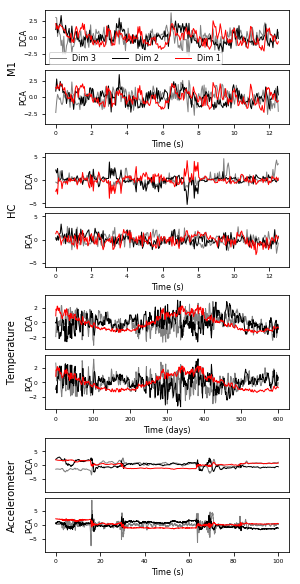

In [6]:
te = .01
be = .05
le = .13
re = .02
lg = .05
sm = .01

h = (1 - te - be - 4*sm - 3*lg) / 8
w = 1 - le - re

fig = plt.figure(figsize=(4, 8))

axes = []
names = ['M1', 'HC', 'Temperature', 'Accelerometer']
colors = ['r', 'k', 'gray']
for ii in range(4):
    x = le
    y = 1 - te - (h * 2 + sm + lg) * ii - h
    fig.text(0, y - sm / 2, names[ii], rotation=90, va='center', ha='left')
    axes.append(fig.add_axes([le, y, w, h]))
    y = y - sm - h
    axes.append(fig.add_axes([le, y, w, h]))

slices = [slice(1000, 1250), slice(2000, 2250), slice(0, 600), slice(2000, 7000)]
bin_sizes = [.05, .05, 1, .02]
for ii, ((X, name, unit), (_, _, Xd, Xp), sl, bs) in enumerate(zip(data, results, slices, bin_sizes)):
    xd = Xd[sl, :]
    xp = Xp[sl, :]
    xd -= xd.mean(axis=0, keepdims=True)
    xd /= xd.std(axis=0, keepdims=True)
    xp -= xp.mean(axis=0, keepdims=True)
    xp /= xp.std(axis=0, keepdims=True)
    maxval = max(abs(xd).max(), abs(xp).max())
    t = np.linspace(0, xd.shape[0] * bs, xd.shape[0])
    for jj in np.arange(dim)[::-1]:
        label = 'Dim {}'.format(jj+1)
        axes[ii*2].plot(t, xd[:, jj], c=colors[jj], label=label, lw=1)
        axes[ii*2+1].plot(t, xp[:, jj], c=colors[jj], lw=1)
        axes[ii*2].set_ylim(-maxval * 1.1, maxval * 1.1)
        axes[ii*2+1].set_ylim(-maxval * 1.1, maxval * 1.1)
        axes[ii*2].set_ylabel('DCA', fontsize=style.axis_label_fontsize, labelpad=-5)
        axes[ii*2].set_xticks([])
        axes[ii*2+1].set_ylabel('PCA', fontsize=style.axis_label_fontsize, labelpad=-5)
        print(spearmanr(Xd[:, jj], Xp[:, jj]))
    print()

axes[0].legend(ncol=3, fontsize=style.axis_label_fontsize,
               loc='lower left', frameon=True, bbox_to_anchor=(0., -.06), borderpad=.15)
axes[1].set_xlabel('Time (s)', fontsize=style.axis_label_fontsize)
axes[3].set_xlabel('Time (s)', fontsize=style.axis_label_fontsize)
axes[5].set_xlabel('Time (days)', fontsize=style.axis_label_fontsize)
axes[7].set_xlabel('Time (s)', fontsize=style.axis_label_fontsize)

for ax in axes:
    ax.tick_params(labelsize=style.ticklabel_fontsize)

plt.savefig('inferred_dynamics_3d.pdf'.format(name))

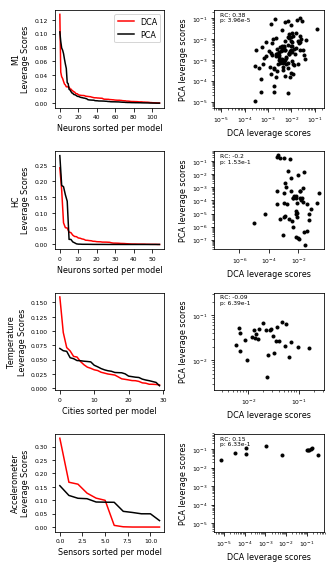

In [7]:
fig, axes_m = plt.subplots(4, 2, figsize=(4.75, 8))

for (_, name, unit), (dca_ls, pca_ls, _, _), axes in zip(data, results, axes_m):
    c, p = spearmanr(dca_ls, pca_ls)
    c = np.round(c, 2)
    pl10 = int(np.floor(np.log10(p)))
    pr = np.round(p / 10**pl10, 2)

    ax = axes[0]
    ax.plot(np.sort(dca_ls)[::-1], c='r', label='DCA')
    ax.plot(np.sort(pca_ls)[::-1], c='k', label='PCA')
    ax.set_xlabel('{} sorted per model'.format(unit), fontsize=style.axis_label_fontsize)
    ax.set_ylabel('{}\nLeverage Scores'.format(name), fontsize=style.axis_label_fontsize)

    ax = axes[1]
    maxval = max(dca_ls.max(), pca_ls.max())
    minval = min(dca_ls.min(), pca_ls.min())
    ax.scatter(dca_ls, pca_ls, marker='.', c='k')
    ax.set_xlabel('DCA leverage scores', fontsize=style.axis_label_fontsize)
    ax.set_ylabel('PCA leverage scores', fontsize=style.axis_label_fontsize)
    ax.set_xlim(minval / 2, maxval*2)
    ax.set_ylim(minval / 2, maxval*2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.text(.05, .98, 'RC: {}\np: {}e{}'.format(c, pr, pl10),
            ha='left', va='top', transform=ax.transAxes, fontsize=style.ticklabel_fontsize)

axes_m[0, 0].legend(fontsize=style.axis_label_fontsize)
for ax in axes_m.ravel():
    ax.tick_params(labelsize=style.ticklabel_fontsize)

fig.tight_layout()
plt.savefig('leverage_scores_3d.pdf'.format(name))